# AdaBoost vs Neural Networks  
### Understanding Two Regression Approaches on the Same Dataset


This notebook compares two very different approaches to regression modeling on the **same dataset**:

- **AdaBoost Regressor** — a tree-based boosting method  
- **Neural Network Regressor (MLP)** — a layered, continuous function learner  

The goal is not just to see *which model performs better*, but to understand **how these models work**, **how they learn from data**, and **what tradeoffs they introduce** when solving a real regression problem.

## What this project is about

- Predicting a continuous target variable using supervised learning  
- Starting from a **simple baseline**, then increasing model complexity  
- Keeping the comparison fair by using the **same data split, preprocessing logic, and evaluation metrics**  
- Interpreting results in a way that makes sense beyond raw performance numbers  

This is a **practical, behavior-focused comparison**, written so that someone browsing this project on GitHub can follow along without prior machine-learning expertise.

## How AdaBoost Learns from Mistakes

AdaBoost is a model that improves performance by **combining many simple decision trees** instead of relying on one complex model.

Rather than learning everything at once, AdaBoost works **in stages**:
- it trains a small decision tree,
- observes where that tree performs poorly,
- then trains the next tree to pay **more attention to those difficult cases**.

Over time, the model becomes a **weighted collection of weak learners**, where each new learner focuses on correcting past errors.

You can think of AdaBoost as:

> *a system that learns by repeatedly asking, “Where did I go wrong last time?” and adjusting its focus accordingly.*



### What does “boosting” mean?

Boosting refers to the idea of **sequential learning**:
- models are trained **one after another**, not independently,
- each new model is influenced by the mistakes of the previous ones.

In AdaBoost, data points that were predicted poorly receive **higher importance**, so future trees prioritize them during training.



### Why AdaBoost uses small trees

AdaBoost typically uses **shallow decision trees** (often called *weak learners*).

Individually, these trees are not very accurate.  
Together, when weighted and combined, they form a **strong predictive model**.

This design:
- reduces overfitting,
- keeps the model focused on learning structure gradually,
- and makes training more stable on tabular data.



### Strengths and limitations

**Strengths**
- Performs well on structured, tabular datasets  
- Naturally handles non-linear relationships  
- More interpretable than many neural network models  

**Limitations**
- Can be sensitive to noisy data or outliers  
- Performance depends on tuning learning rate and number of estimators  
- Less effective on very large or high-dimensional feature spaces

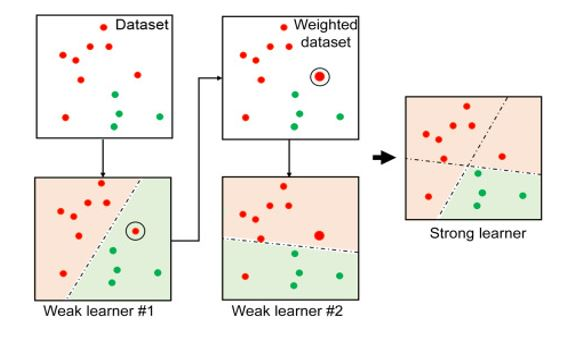

*Each successive tree is trained to focus more on observations that previous trees predicted poorly.*

## How a Neural Network Learns Patterns

A neural network is a model designed to learn complex relationships by **transforming inputs step by step**.

Instead of making decisions using rules or splits (like decision trees), a neural network learns by:
- combining inputs using weighted connections,
- passing them through multiple layers,
- and gradually adjusting those weights to reduce prediction error.

Each layer learns a slightly more abstract version of the data than the one before it.

You can think of a neural network as:

> *a system that learns a flexible mathematical function by repeatedly refining itself until predictions improve.*



### What does “multi-layer perceptron (MLP)” mean?

- **Perceptron**: a basic unit that takes inputs, applies weights, and produces an output  
- **Multi-layer**: many of these units stacked in layers  

An **MLP regressor** connects:
- an **input layer** (your features),
- one or more **hidden layers** (where patterns are learned),
- and an **output layer** that produces a single continuous prediction.



### How learning actually happens

During training, the neural network:
1. Makes a prediction  
2. Measures how wrong that prediction is  
3. Slightly adjusts all internal weights to reduce that error  
4. Repeats this process many times  

Unlike AdaBoost, which explicitly focuses on past mistakes, a neural network improves by **small, continuous adjustments across the entire model**.



### Why neural networks are powerful — and tricky

Neural networks are very flexible:
- they can model smooth curves,
- capture complex interactions,
- and adapt to subtle patterns in the data.

At the same time, this flexibility means:
- they require careful tuning,
- they depend heavily on feature scaling,
- and their internal logic is harder to interpret than tree-based models.

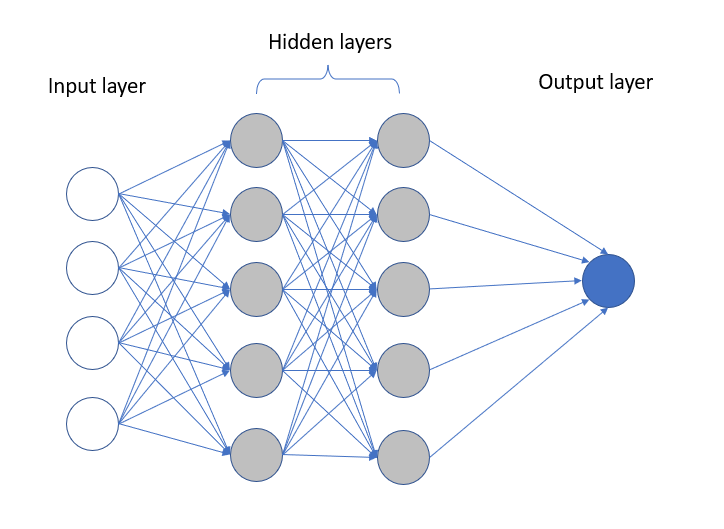

*Inputs are transformed layer by layer, allowing the model to learn increasingly complex representations of the data.*

## Table of Contents

1. [Setup](#setup)  
2. [Dataset Overview](#dataset-overview)  
3. [Exploratory Data Analysis](#exploratory-data-analysis)  
4. [Problem Setup & Evaluation Metrics](#problem-setup--evaluation-metrics)  
5. [Preprocessing Pipelines](#preprocessing-pipelines)  
6. [Baseline Model](#baseline-model)  
7. [AdaBoost Regressor](#adaboost-regressor)  
8. [Neural Network Regressor](#neural-network-regressor)  
9. [Model Comparison](#model-comparison)  
10. [Interpretation & Explainability](#interpretation--explainability)  
11. [Save Artifacts](#save-artifacts)  
12. [Conclusion & Next Steps](#conclusion--next-steps)

## Setup

This section sets up the environment used throughout the notebook.

The goal here is simple:
- keep results **reproducible**,
- separate configuration from modeling logic,
- and make it clear which tools are used before we touch the data.

No modeling happens yet — this is just groundwork.


### Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm.auto import tqdm

# Scikit-learn utilities
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer


# Models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Model persistence
import joblib

### Global Configurations and Helpers

In [2]:
# Reproducibility
RANDOM_STATE = 42

# Plot style (clean and readable)
plt.style.use("seaborn-v0_8")

# Artifacts directory
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Metric helpers
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_regression(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

## Dataset Overview

Before building any models, it’s important to understand **what data we are working with** and **what the prediction task actually is**.

This section introduces the dataset, explains what each row represents, and clarifies the target variable we are trying to predict.


### Load and Inspect the Dataset

In [3]:
# Load the California Housing dataset
data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

print("Dataset shape:", X.shape)
print("Target variable:", data.target_names[0])
print("Feature names:", data.feature_names)
print("First few rows of the dataset:")
print(data.frame.head())

Dataset shape: (20640, 8)
Target variable: MedHouseVal
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
First few rows of the dataset:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


### What does this dataset represent?

This project uses the **California Housing dataset**, a regression dataset derived from the **1990 California census** and made available through scikit-learn.

Each row in the dataset corresponds to a **geographic block group**.

A block group is a small geographic unit that aggregates demographic and housing information for a local area, such as income levels, population density, and housing characteristics.
The target variable represents the **median house value** for each block group, measured in hundreds of thousands of dollars.

### What is the prediction task?

The goal is to predict the **median house value** for each block group using a set of numerical features.

This is a **supervised regression problem**, where:
- the inputs are structured, tabular features,
- the output is a single continuous value.

### Target variable

- **Name:** `MedHouseVal`  
- **Meaning:** Median house value within a block group  
- **Units:** Hundreds of thousands of U.S. dollars  

For example, a target value of `2.5` corresponds to an approximate median house value of **$250,000**.

### Feature overview

The input features describe aggregated characteristics of each block group, including:

- income-related measures (e.g. median income),
- housing characteristics (e.g. average number of rooms),
- population and household statistics,
- geographic information (latitude and longitude).

All features in this dataset are **numerical**, which makes it suitable for both:
- tree-based models such as **AdaBoost**,
- neural network models such as a **multi-layer perceptron (MLP)**.

## Exploratory Data Analysis

This section takes a quick look at the dataset to understand:
- its size and structure,
- whether there are missing values,
- how the target variable is distributed,
- and which features appear most related to the target.

The goal here is **context**, not deep statistical analysis.


### Data Summary

In [4]:
# Basic information about the dataset
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [5]:
# Summary statistics
X.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000


A few important observations emerge from the basic dataset summary:

- The dataset contains **20,640 observations** and **8 numerical features**, with **no missing values**.  
  This means the data is already clean, and imputation during preprocessing is mainly a safety measure.

- Feature scales vary significantly across variables.  
  For example, `MedInc` ranges from roughly 0.5 to 15, while `Population` and `AveOccup` can take very large values.

- Several features show **heavy tails and extreme values**, particularly `AveRooms`, `AveOccup`, and `Population`.  
  These outliers can disproportionately affect error-based metrics such as RMSE.

These characteristics help motivate later design choices:
- **feature scaling** is essential for neural networks,
- tree-based models like **AdaBoost** are expected to be more robust to differences in feature scale,
- using multiple evaluation metrics (RMSE, MAE, R²) provides a more complete view of performance.


### Target distribution

Understanding the distribution of the target variable helps interpret model errors and performance metrics.

In particular, it tells us whether:
- values are skewed,
- extreme values are present,
- and what a “typical” prediction error might look like.

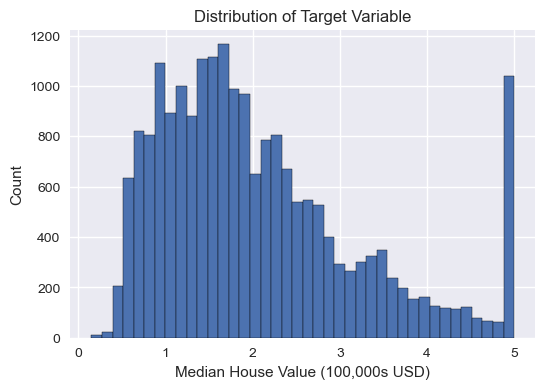

In [6]:
plt.figure(figsize=(6, 4))
plt.hist(y, bins=40, edgecolor="black")
plt.xlabel("Median House Value (100,000s USD)")
plt.ylabel("Count")
plt.title("Distribution of Target Variable")
plt.show()

The target variable is **right-skewed**, with most observations concentrated at lower and mid-range house values.

A notable feature of this dataset is the **sharp spike at the upper bound (5.0)**.  
This reflects an artificial cap in the data, where house values above a certain threshold were truncated.

This has several implications:
- the model cannot distinguish between truly high-value properties beyond the cap,
- prediction errors near the upper bound are harder to interpret,
- large errors on high-value observations can disproportionately affect RMSE.

Because of these characteristics, model performance is evaluated using **multiple metrics** (RMSE, MAE, and R²) rather than relying on a single score.

### Feature relationships

To get an initial sense of which features are related to house values, we examine correlations between the input features and the target.

This is not used for feature selection, but as a **sanity check** and intuition builder.

In [7]:
# Correlation of each feature with the target
corr_with_target = X.assign(MedHouseVal=y).corr()["MedHouseVal"].sort_values(ascending=False)

corr_with_target

MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64

Median income (`MedInc`) shows a strong positive correlation with house values, making it the most influential feature in a linear sense.

Most other features exhibit relatively weak linear correlation with the target.  
This does not imply that these features are unimportant — rather, it suggests that their effects may be **non-linear** or dependent on interactions with other variables.

These observations help motivate the use of flexible models such as **AdaBoost** and **Neural Networks**, which are better suited to capturing non-linear patterns and feature interactions than simple linear approaches.


### Key observations from exploratory analysis

Several important characteristics of the dataset emerge from the exploratory analysis:

- The dataset is **clean and fully numerical**, with no missing values across 20,640 observations.  
  This allows modeling to focus on learning patterns rather than handling data quality issues.

- Feature scales vary substantially across variables, and several features (such as `Population`, `AveRooms`, and `AveOccup`) exhibit **heavy tails and extreme values**.  
  This motivates careful metric selection and highlights the importance of feature scaling for neural networks.

- The target variable is **right-skewed** and exhibits a **hard upper cap**, indicating that very high house values are truncated in the data.  
  This introduces asymmetry in prediction errors and makes it important to evaluate models using multiple metrics rather than a single score.

- Median income (`MedInc`) shows a strong linear relationship with house values, while most other features display weak individual correlations.  
  This suggests that **non-linear effects and feature interactions** play a significant role in determining house prices.

Taken together, these observations justify the use of **flexible, non-linear models** such as AdaBoost and Neural Networks, and inform the preprocessing and evaluation choices used in later sections.

## Problem Setup & Evaluation Metrics

This section defines how the modeling problem is structured and how model performance will be evaluated.

The goal is to ensure that:
- all models are compared **fairly**,
- evaluation reflects **realistic prediction quality**,
- and results can be interpreted beyond a single number.

### Problem formulation

The task is a **supervised regression problem**:

- **Inputs:** Structured, numerical features describing demographic, housing, and geographic characteristics  
- **Output:** A single continuous target variable representing median house value

All models are trained to learn a mapping from features to house values using the same data and evaluation protocol.


In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=RANDOM_STATE
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (16512, 8)
Test set size: (4128, 8)


### Why a train/test split?

A single train/test split is used to:
- simulate how models perform on **unseen data**,
- avoid information leakage,
- and ensure a **fair, like-for-like comparison** across models.

All models use **the same split**, so any performance differences can be attributed to the modeling approach rather than data variation.

### Evaluation metrics

Multiple metrics are used to evaluate model performance, each highlighting a different aspect of prediction quality:

- **RMSE (Root Mean Squared Error)**  
  Measures the typical prediction error while penalizing large mistakes more heavily.  
  RMSE is used as the **primary optimization metric** during model tuning.

- **MAE (Mean Absolute Error)**  
  Represents the average absolute prediction error and is less sensitive to extreme values.  
  This provides a more robust view of typical model performance.

- **R² (Coefficient of Determination)**  
  Indicates how much of the variance in the target variable is explained by the model.  
  This helps contextualize model performance in relative terms.

While models are tuned using RMSE, conclusions are drawn by considering **all three metrics together**.

## Preprocessing Pipelines

Before training any models, the input data must be prepared in a consistent and appropriate way.

This section defines how features are transformed prior to modeling, and explains **why preprocessing differs between tree-based models and neural networks**.


### Preprocessing principles

The preprocessing strategy follows three key principles:

1. **Consistency**  
   All models use the same raw features and the same train/test split.

2. **Model-appropriate transformations**  
   Different models have different sensitivities to feature scale.

3. **Pipeline-based design**  
   Preprocessing is encapsulated in scikit-learn pipelines to prevent data leakage and ensure reproducibility.

### Why preprocessing differs by model

Tree-based models (such as AdaBoost with decision trees):
- are **invariant to feature scaling**,
- split data based on relative order rather than absolute magnitude,
- are generally robust to differences in feature scale.

Neural networks, on the other hand:
- rely on gradient-based optimization,
- are **sensitive to feature scale**,
- train more reliably when input features are standardized.

For this reason, two preprocessing pipelines are defined:
- one for **tree-based models**, without scaling,
- one for **neural networks**, with feature scaling applied.

In [9]:
# Identify numeric and categorical columns
numeric_features = X.columns.tolist()
categorical_features = []  # All features are numeric in this dataset

numeric_features, categorical_features

(['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 [])

### Preprocessing for Tree-based Models

In [10]:
numeric_transformer_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_tree, numeric_features)
    ],
    remainder="drop"
)

### Preprocessing for Neural Networks

In [11]:
numeric_transformer_nn = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess_nn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_nn, numeric_features)
    ],
    remainder="drop"
)


### Why use preprocessing pipelines?

Encapsulating preprocessing steps inside pipelines ensures that:
- transformations are learned **only from training data**,
- the same transformations are applied to unseen test data,
- data leakage is avoided during model evaluation.

This approach also makes it easy to swap models while keeping the preprocessing logic explicit and reproducible.


## Baseline Model

Before training more complex models, it is important to establish a **baseline**.

A baseline model answers a simple question:
> *How well could we do without learning any meaningful patterns from the data?*

If a complex model cannot clearly outperform this baseline, then added complexity is not justified.

### Baseline choice

The baseline used here is a **Dummy Regressor** that always predicts the **mean** of the target variable from the training data.

This baseline:
- ignores all input features,
- does not learn relationships or interactions,
- provides a minimum performance bar that all other models should exceed.

In [12]:
# Baseline model pipeline
baseline_model = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", DummyRegressor(strategy="mean"))
])


In [13]:
# Train baseline model
baseline_model.fit(X_train, y_train)

# Predict on test set
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate baseline performance
baseline_results = evaluate_regression(y_test, y_pred_baseline)

# Display results
pd.DataFrame([baseline_results], index=["Baseline (Mean)"]).style.format("{:.4f}").set_caption("Baseline Model Performance")

,RMSE,MAE,R2
Baseline (Mean),1.1449,0.9061,-0.0002


## AdaBoost Regressor

The first learning-based model explored in this notebook is the **AdaBoost Regressor**.

AdaBoost represents a step up from the baseline by learning patterns from the data while still maintaining a relatively interpretable, structured modeling approach.

### Why use AdaBoost?

AdaBoost is well suited for this problem because:

- the dataset is **structured and tabular**,  
- relationships between features and the target are **non-linear**,  
- feature interactions are likely important,  
- and tree-based models are robust to differences in feature scale.

Unlike a single decision tree, AdaBoost combines many weak learners to gradually improve performance by focusing on difficult cases.

### Model configuration

AdaBoost is used here with **shallow decision trees** as base learners.

Key design choices:
- **Shallow trees** limit overfitting and encourage gradual learning.
- A **learning rate** controls how strongly each new tree influences the final model.
- The **number of estimators** determines how many boosting steps are performed.

These parameters balance model flexibility and generalization.

### AdaBoost regressor pipeline

In [14]:
# AdaBoost regressor pipeline
adaboost_model = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", AdaBoostRegressor(
        estimator=DecisionTreeRegressor(
            max_depth=3,
            random_state=RANDOM_STATE
        ),
        random_state=RANDOM_STATE
    ))
])

### Hyperparameter grid for AdaBoost


In [15]:
adaboost_param_grid = {
    "model__n_estimators": [100, 300, 500],
    "model__learning_rate": [0.05, 0.1, 0.3]
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

adaboost_grid = GridSearchCV(
    adaboost_model,
    param_grid=adaboost_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

### Train and tune AdaBoost

In [16]:
print("Training AdaBoost with GridSearchCV...")
with tqdm(total=1, desc="AdaBoost GridSearch") as pbar:
    adaboost_grid.fit(X_train, y_train)
    pbar.update(1)

best_adaboost = adaboost_grid.best_estimator_
print(f"✓ Best parameters found: {adaboost_grid.best_params_}")

Training AdaBoost with GridSearchCV...


AdaBoost GridSearch:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits
✓ Best parameters found: {'model__learning_rate': 0.05, 'model__n_estimators': 100}


### Evaluation

In [17]:
# Predictions on test set
y_pred_adaboost = best_adaboost.predict(X_test)

# Evaluate performance
adaboost_results = evaluate_regression(y_test, y_pred_adaboost)

# Display results
pd.DataFrame([adaboost_results], index=["AdaBoost"]).style.format("{:.4f}").set_caption("AdaBoost Regressor Performance")

,RMSE,MAE,R2
AdaBoost,0.7508,0.5868,0.5699


## Neural Network Regressor


This section explores a **Neural Network regressor (Multi-Layer Perceptron, MLP)** as a contrasting modeling approach to AdaBoost.

While AdaBoost builds predictions by combining many shallow decision trees, a neural network learns a flexible, continuous function by adjusting weights through layered transformations.

### Why use a neural network?

A neural network is included to answer a practical question:

> *Can a flexible, gradient-based model outperform a strong tree-based benchmark on this dataset?*

Neural networks are well suited for:
- capturing smooth non-linear relationships,
- modeling complex interactions between features,
- learning from scaled numerical inputs.

However, they typically require:
- careful preprocessing,
- hyperparameter tuning,
- and stronger regularization to avoid overfitting.


### Model configuration

The neural network used here is a **Multi-Layer Perceptron (MLP)** with:
- two hidden layers,
- ReLU activation functions,
- L2 regularization,
- and early stopping based on validation performance.

Feature scaling is applied as part of the preprocessing pipeline, which is essential for stable neural network training.

### Neural network regressor pipeline

In [18]:
nn_model = Pipeline(steps=[
    ("preprocess", preprocess_nn),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=2000,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=25,
        random_state=RANDOM_STATE
    ))
])

### Hyperparameter grid for neural network

In [19]:
nn_param_grid = {
    "model__hidden_layer_sizes": [(64, 32), (128, 64), (128, 64, 32)],
    "model__alpha": [1e-5, 1e-4, 1e-3],
    "model__learning_rate_init": [5e-4, 1e-3]
}

nn_grid = GridSearchCV(
    nn_model,
    param_grid=nn_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

### Train and tune neural network

In [20]:
print("Training Neural Network with GridSearchCV...")
with tqdm(total=1, desc="Neural Network GridSearch") as pbar:
    nn_grid.fit(X_train, y_train)
    pbar.update(1)

best_nn = nn_grid.best_estimator_
print(f"✓ Best parameters found: {nn_grid.best_params_}")

Training Neural Network with GridSearchCV...


Neural Network GridSearch:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 18 candidates, totalling 90 fits
✓ Best parameters found: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (128, 64), 'model__learning_rate_init': 0.001}


### Evaluate

In [21]:
# Predictions on test set
y_pred_nn = best_nn.predict(X_test)

# Evaluate performance
nn_results = evaluate_regression(y_test, y_pred_nn)

# Display results
pd.DataFrame([nn_results], index=["Neural Network"]).style.format("{:.4f}").set_caption("Neural Network Regressor Performance")

,RMSE,MAE,R2
Neural Network,0.5208,0.3519,0.7930


### Interpreting neural network performance

The neural network regressor delivers a **substantial improvement** over both the baseline and the AdaBoost model.

- RMSE decreases from **1.14 (baseline)** and **0.75 (AdaBoost)** to **0.52**, representing a **54% reduction** relative to the baseline and a **31% reduction** relative to AdaBoost.
- MAE drops to **0.35**, indicating significantly smaller typical prediction errors.
- An R² of **0.79** shows that the neural network explains nearly **80% of the variance** in median house values.

These results indicate that the neural network is effectively capturing complex, non-linear relationships and feature interactions that the tree-based boosting model does not fully exploit.

While this performance gain comes at the cost of reduced interpretability and increased sensitivity to preprocessing and hyperparameters, it demonstrates that a well-regularized neural network can outperform a strong tree-based benchmark on this dataset.

The neural network therefore emerges as the **best-performing model** in terms of predictive accuracy, setting the stage for a direct comparison and final recommendation in the next section.

## Model Comparison

This section compares all models side by side using the **same test set** and **the same evaluation metrics**.

The objective is to:
- quantify performance differences,
- understand tradeoffs between accuracy and interpretability,
- and determine which model is most appropriate given the problem and data.


In [22]:
# Combine results into a single table
comparison_df = pd.DataFrame({
    "RMSE": {
        "Baseline (Mean)": baseline_results["RMSE"],
        "AdaBoost": adaboost_results["RMSE"],
        "Neural Network": nn_results["RMSE"],
    },
    "MAE": {
        "Baseline (Mean)": baseline_results["MAE"],
        "AdaBoost": adaboost_results["MAE"],
        "Neural Network": nn_results["MAE"],
    },
    "R2": {
        "Baseline (Mean)": baseline_results["R2"],
        "AdaBoost": adaboost_results["R2"],
        "Neural Network": nn_results["R2"],
    }
})

comparison_df

,RMSE,MAE,R2
Baseline (Mean),1.144856,0.906069,-0.000219
AdaBoost,0.750765,0.586818,0.569868
Neural Network,0.520762,0.351948,0.793047


### How to read these results

- **RMSE** reflects overall error magnitude and penalizes large mistakes.
- **MAE** represents the typical absolute prediction error.
- **R²** indicates how much variance in house values is explained by the model.

Lower values are better for RMSE and MAE, while higher values are better for R².

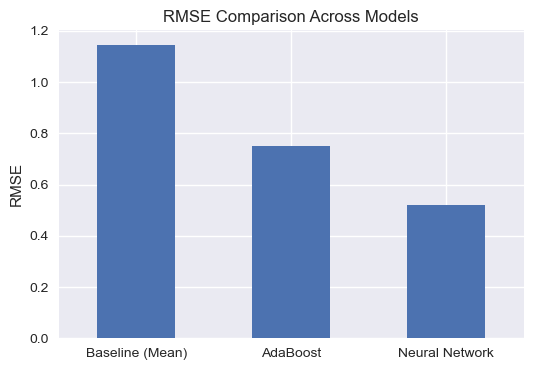

In [23]:
# Visual comparison of RMSE
plt.figure(figsize=(6, 4))
comparison_df["RMSE"].plot(kind="bar")
plt.ylabel("RMSE")
plt.title("RMSE Comparison Across Models")
plt.xticks(rotation=0)
plt.show()


### Interpreting the comparison

Several clear patterns emerge from the comparison:

- The **baseline model** performs poorly across all metrics, confirming that meaningful structure exists in the data.
- **AdaBoost** delivers a strong improvement over the baseline, reducing error substantially and explaining over half of the variance.
- The **neural network** achieves the best performance across all metrics, with the lowest RMSE and MAE and the highest R².

In particular:
- the neural network reduces RMSE by approximately **31%** relative to AdaBoost,
- and explains nearly **80%** of the variance in house values.

This indicates that the neural network is better able to capture complex, non-linear relationships present in the data.

### Tradeoffs and context

While the neural network achieves the strongest predictive performance, the choice of model depends on priorities:

- **Neural Network**
  - Best accuracy
  - Higher sensitivity to preprocessing and hyperparameters
  - Lower interpretability

- **AdaBoost**
  - Strong performance on tabular data
  - More interpretable than neural networks
  - Less sensitive to feature scaling

In settings where interpretability and robustness are critical, AdaBoost remains a strong option.  
In settings where predictive accuracy is the primary goal, the neural network is the preferred choice.

## Interpretation & Explainability

Predictive performance alone is not always sufficient.  
Understanding **why** a model makes certain predictions can be just as important, especially in real-world decision-making.

This section focuses on interpreting model behavior using:
- residual analysis,
- permutation feature importance,
- and partial dependence plots.

These tools help translate model outputs into actionable insights.

### Residual analysis

A **residual** is the difference between the actual value and the model’s prediction.

Analyzing residuals helps answer questions such as:
- Are errors centered around zero?
- Does the model systematically over- or under-predict?
- Are large errors concentrated in specific regions?

Residual analysis provides a sanity check on model behavior beyond aggregate metrics.

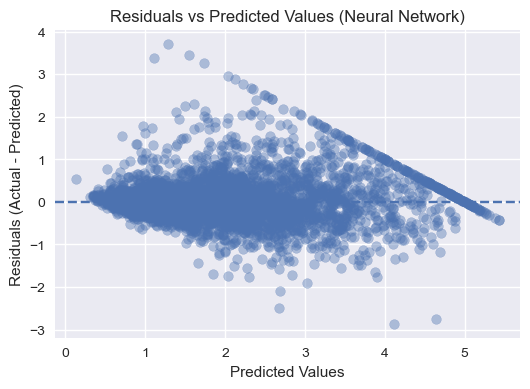

In [24]:
# Residuals for neural network
residuals_nn = y_test - y_pred_nn

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_nn, residuals_nn, alpha=0.4)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Values (Neural Network)")
plt.show()

### Interpreting neural network residuals

The residual plot shows that errors are generally centered around zero across the prediction range, indicating no strong systematic bias in the model.

As predicted house values increase, the spread of residuals becomes wider.  
This suggests higher uncertainty when predicting more expensive properties, which is consistent with the right-skewed target distribution and the presence of a hard upper cap in the data.

The sharp diagonal boundary near the maximum predicted values reflects this cap and is an expected artifact of the dataset rather than a modeling issue.

Overall, the absence of strong patterns or curvature in the residuals indicates that the neural network has captured most of the structured signal in the data, with remaining errors largely random in nature.

### Feature importance (permutation-based)

To understand which features matter most, we use **permutation feature importance**.

This method works by:
- randomly shuffling one feature at a time,
- measuring how much model performance degrades,
- and interpreting larger performance drops as higher importance.

Permutation importance is model-agnostic and works consistently for both tree-based models and neural networks.

In [25]:
# Permutation importance for neural network
perm_importance_nn = permutation_importance(
    best_nn,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="neg_root_mean_squared_error"
)

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": perm_importance_nn.importances_mean
}).sort_values("Importance", ascending=False)

importance_df

,Feature,Importance
6,Latitude,1.157177
7,Longitude,1.018712
2,AveRooms,0.459597
0,MedInc,0.415308
3,AveBedrms,0.350133
5,AveOccup,0.212551
1,HouseAge,0.082816
4,Population,0.018919


### Interpreting permutation feature importance

Permutation importance highlights which features the model relies on most for accurate predictions.

Geographic features (`Latitude` and `Longitude`) emerge as the most influential variables, indicating that **location plays a dominant role** in determining house values. These features implicitly capture regional effects such as urbanization, proximity to high-demand areas, and local economic conditions.

Housing and income-related features (`AveRooms`, `MedInc`, and `AveBedrms`) also contribute meaningfully, but their importance is secondary to geographic context. This suggests that structural characteristics and income influence prices **within** location-driven constraints.

Population-related variables (`Population`, `AveOccup`, and `HouseAge`) show lower standalone importance. This does not imply irrelevance; rather, their effects are likely expressed through **interactions with other features**.

Overall, this importance pattern reinforces the need for flexible, non-linear models and aligns with the strong performance observed for the neural network.

### Partial dependence plots

A **partial dependence plot (PDP)** shows how the model’s predictions change as a single feature varies, while all other features are held constant.

PDPs help answer questions such as:
- *How does predicted house value change as income increases?*
- *Is the relationship linear or non-linear?*

These plots are especially useful for interpreting complex models.

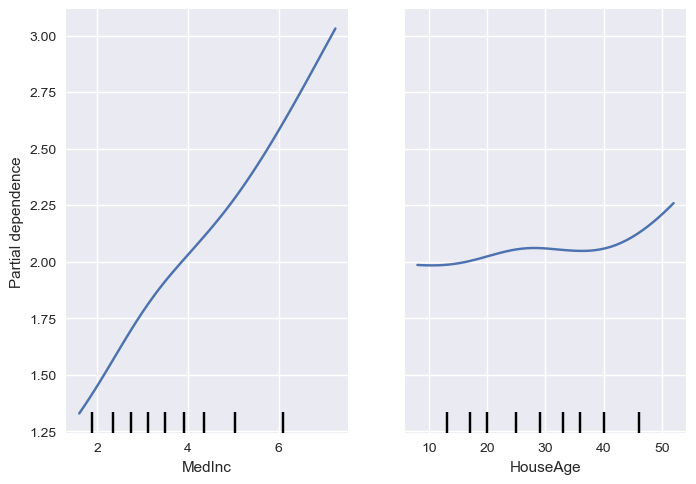

In [26]:
# Partial dependence plots for selected features
features_to_plot = ["MedInc", "HouseAge"]

PartialDependenceDisplay.from_estimator(
    best_nn,
    X_test,
    features_to_plot,
    grid_resolution=50
)

plt.show()

### Why these features were chosen for PDP analysis

Partial dependence plots are most informative when applied to features that are both influential and interpretable.

`MedInc` is included because it is one of the strongest drivers of house values and exhibits clear non-linear behavior. Its PDP helps illustrate how predicted values increase with income while showing diminishing returns at higher levels.

`HouseAge` is included as a contrasting example. Although it shows weak linear correlation with the target, the PDP reveals how the model captures more subtle, non-linear effects that are not visible through correlation analysis alone.

Geographic features such as latitude and longitude, while highly important, are not included in PDPs because their one-dimensional partial dependence is difficult to interpret meaningfully.

### Interpreting partial dependence plots

The partial dependence plot for median income (`MedInc`) shows a strong, monotonic increase in predicted house values, with diminishing returns at higher income levels. This indicates that income is a dominant driver of prices, but its marginal effect decreases as income rises, highlighting a non-linear relationship.

In contrast, the partial dependence plot for house age (`HouseAge`) reveals a subtle, non-monotonic pattern. Predicted values remain relatively stable across much of the range, with mild variation at higher ages. This suggests that house age influences prices primarily through interactions with other features rather than as a standalone driver.

Together, these plots illustrate how the neural network captures both strong non-linear effects and more nuanced patterns that are not apparent from linear correlation alone.

## Save Artifacts

This section persists all trained models, evaluation results, and visualizations to the `artifacts/` directory for reproducibility and future reference.

Saved artifacts include:
- **Trained models** (AdaBoost and Neural Network pipelines)
- **Evaluation metrics** (comparison table as CSV)
- **Visualizations** (RMSE comparison, residual plot, partial dependence plots)

### Save trained models

Persist the trained model pipelines (including preprocessing steps) so they can be reloaded later without retraining.

In [27]:
# Save AdaBoost model
adaboost_path = os.path.join(ARTIFACTS_DIR, "adaboost_regressor.joblib")
joblib.dump(best_adaboost, adaboost_path)

# Save Neural Network model
nn_path = os.path.join(ARTIFACTS_DIR, "neural_network_regressor.joblib")
joblib.dump(best_nn, nn_path)

print("✓ Models saved successfully!")
print(f"  - {adaboost_path}")
print(f"  - {nn_path}")

✓ Models saved successfully!
  - artifacts\adaboost_regressor.joblib
  - artifacts\neural_network_regressor.joblib


### Save evaluation results

Export the model comparison metrics and individual model results to CSV files for easy reference.

In [28]:
# Save model comparison results
comparison_path = os.path.join(ARTIFACTS_DIR, "model_comparison.csv")
comparison_df.to_csv(comparison_path)

# Save individual model results
adaboost_results_df = pd.DataFrame([adaboost_results], index=["AdaBoost"])
adaboost_results_path = os.path.join(ARTIFACTS_DIR, "adaboost_results.csv")
adaboost_results_df.to_csv(adaboost_results_path)

nn_results_df = pd.DataFrame([nn_results], index=["Neural Network"])
nn_results_path = os.path.join(ARTIFACTS_DIR, "neural_network_results.csv")
nn_results_df.to_csv(nn_results_path)

print("✓ Evaluation results saved successfully!")
print(f"  - {comparison_path}")
print(f"  - {adaboost_results_path}")
print(f"  - {nn_results_path}")

✓ Evaluation results saved successfully!
  - artifacts\model_comparison.csv
  - artifacts\adaboost_results.csv
  - artifacts\neural_network_results.csv


### Save visualizations

Export key plots from the AdaBoost, Neural Network, and Model Comparison sections as image files.

In [29]:
# Save RMSE comparison bar chart
fig_rmse, ax_rmse = plt.subplots(figsize=(6, 4))
comparison_df["RMSE"].plot(kind="bar", ax=ax_rmse)
ax_rmse.set_ylabel("RMSE")
ax_rmse.set_title("RMSE Comparison Across Models")
ax_rmse.set_xticklabels(ax_rmse.get_xticklabels(), rotation=0)
rmse_plot_path = os.path.join(ARTIFACTS_DIR, "rmse_comparison.png")
fig_rmse.savefig(rmse_plot_path, dpi=150, bbox_inches="tight")
plt.close(fig_rmse)

# Save AdaBoost predictions vs actual plot
fig_ada, ax_ada = plt.subplots(figsize=(6, 4))
ax_ada.scatter(y_test, y_pred_adaboost, alpha=0.4)
ax_ada.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
ax_ada.set_xlabel("Actual Values")
ax_ada.set_ylabel("Predicted Values")
ax_ada.set_title("AdaBoost: Predicted vs Actual")
adaboost_plot_path = os.path.join(ARTIFACTS_DIR, "adaboost_predictions.png")
fig_ada.savefig(adaboost_plot_path, dpi=150, bbox_inches="tight")
plt.close(fig_ada)

# Save Neural Network predictions vs actual plot
fig_nn, ax_nn = plt.subplots(figsize=(6, 4))
ax_nn.scatter(y_test, y_pred_nn, alpha=0.4)
ax_nn.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
ax_nn.set_xlabel("Actual Values")
ax_nn.set_ylabel("Predicted Values")
ax_nn.set_title("Neural Network: Predicted vs Actual")
nn_plot_path = os.path.join(ARTIFACTS_DIR, "neural_network_predictions.png")
fig_nn.savefig(nn_plot_path, dpi=150, bbox_inches="tight")
plt.close(fig_nn)

# Save Neural Network residuals plot
fig_resid, ax_resid = plt.subplots(figsize=(6, 4))
residuals_nn = y_test - y_pred_nn
ax_resid.scatter(y_pred_nn, residuals_nn, alpha=0.4)
ax_resid.axhline(0, linestyle="--")
ax_resid.set_xlabel("Predicted Values")
ax_resid.set_ylabel("Residuals (Actual - Predicted)")
ax_resid.set_title("Residuals vs Predicted Values (Neural Network)")
residuals_plot_path = os.path.join(ARTIFACTS_DIR, "neural_network_residuals.png")
fig_resid.savefig(residuals_plot_path, dpi=150, bbox_inches="tight")
plt.close(fig_resid)

# Save Partial Dependence Plot
fig_pdp, ax_pdp = plt.subplots(figsize=(10, 4))
features_to_plot = ["MedInc", "HouseAge"]
PartialDependenceDisplay.from_estimator(
    best_nn,
    X_test,
    features_to_plot,
    grid_resolution=50,
    ax=ax_pdp
)
pdp_plot_path = os.path.join(ARTIFACTS_DIR, "partial_dependence.png")
fig_pdp.savefig(pdp_plot_path, dpi=150, bbox_inches="tight")
plt.close(fig_pdp)

print("✓ Visualizations saved successfully!")
print(f"  - {rmse_plot_path}")
print(f"  - {adaboost_plot_path}")
print(f"  - {nn_plot_path}")
print(f"  - {residuals_plot_path}")
print(f"  - {pdp_plot_path}")

✓ Visualizations saved successfully!
  - artifacts\rmse_comparison.png
  - artifacts\adaboost_predictions.png
  - artifacts\neural_network_predictions.png
  - artifacts\neural_network_residuals.png
  - artifacts\partial_dependence.png


### Artifacts summary

All artifacts have been saved to the `artifacts/` directory. Here's a summary of what was saved:

In [30]:
# List all saved artifacts
print("=" * 50)
print("ARTIFACTS SUMMARY")
print("=" * 50)

artifacts_list = os.listdir(ARTIFACTS_DIR)
print(f"\nDirectory: {ARTIFACTS_DIR}/")
print("-" * 50)

models = [f for f in artifacts_list if f.endswith(".joblib")]
results = [f for f in artifacts_list if f.endswith(".csv")]
plots = [f for f in artifacts_list if f.endswith(".png")]

print("\n📦 Trained Models:")
for m in models:
    size = os.path.getsize(os.path.join(ARTIFACTS_DIR, m)) / 1024
    print(f"   • {m} ({size:.1f} KB)")

print("\n📊 Evaluation Results:")
for r in results:
    print(f"   • {r}")

print("\n📈 Visualizations:")
for p in plots:
    print(f"   • {p}")

print("\n" + "=" * 50)
print(f"Total: {len(artifacts_list)} artifacts saved")
print("=" * 50)

ARTIFACTS SUMMARY

Directory: artifacts/
--------------------------------------------------

📦 Trained Models:
   • adaboost_regressor.joblib (139.0 KB)
   • neural_network_regressor.joblib (232.8 KB)

📊 Evaluation Results:
   • adaboost_results.csv
   • model_comparison.csv
   • neural_network_results.csv

📈 Visualizations:
   • adaboost_predictions.png
   • neural_network_predictions.png
   • neural_network_residuals.png
   • partial_dependence.png
   • rmse_comparison.png

Total: 11 artifacts saved


## Conclusion & Next Steps

This project compared two fundamentally different regression approaches—**AdaBoost** and a **Neural Network (MLP)**—using the same dataset, preprocessing strategy, and evaluation framework.

Several key conclusions emerge from the analysis:

- A simple baseline model that ignores feature information performs poorly, confirming that meaningful structure exists in the data.
- AdaBoost delivers a strong improvement over the baseline by capturing non-linear relationships and feature interactions common in tabular datasets.
- The neural network achieves the best overall performance, reducing error substantially and explaining nearly **80% of the variance** in house values.
- Interpretation tools such as residual analysis, permutation importance, and partial dependence plots show that the neural network captures both dominant drivers (e.g. median income) and more subtle, interaction-driven effects (e.g. house age).

Overall, this comparison highlights a key tradeoff:
- **tree-based boosting methods** offer robustness and interpretability,
- **neural networks** offer superior predictive accuracy when properly tuned and scaled.


### Next steps

There are several directions in which this work could be extended:

- Explore **ensemble approaches** that combine tree-based and neural network predictions.
- Investigate **geographic feature engineering**, such as spatial clustering or distance-based features.
- Evaluate model performance under different **train/test splits** or using nested cross-validation.
- Incorporate **model uncertainty estimates** to better quantify prediction confidence.
- Compare results with simpler linear or regularized models to further contextualize performance gains.

This project demonstrates how careful data understanding, thoughtful model selection, and clear interpretation can lead to meaningful improvements in predictive modeling.